In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import TensorFlow and its components
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, Flatten, Dense, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Import scikit-learn functions for model evaluation and data manipulation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

# Import imbalanced data handling library
from imblearn.over_sampling import RandomOverSampler

# Import Keras utility for model loading
from keras.models import load_model

# Import OpenCV for image processing
import os
import cv2

# Import Keras utility for one-hot encoding
from keras.utils import to_categorical


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
1000
2000
3000
4000
5000
6000


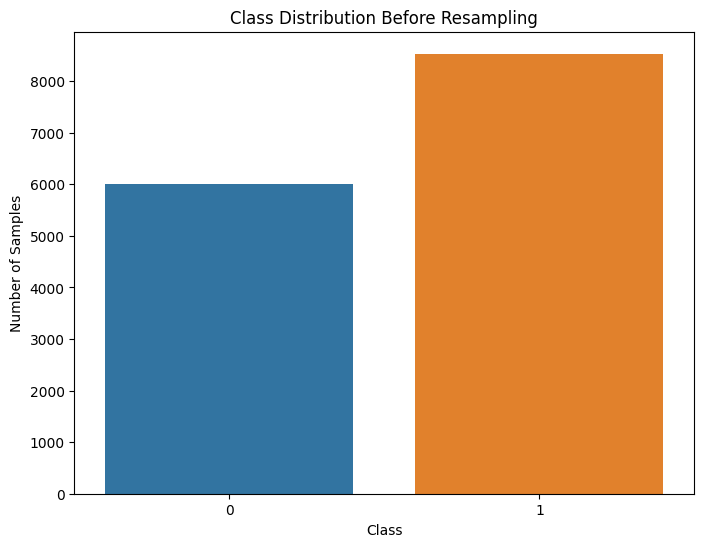

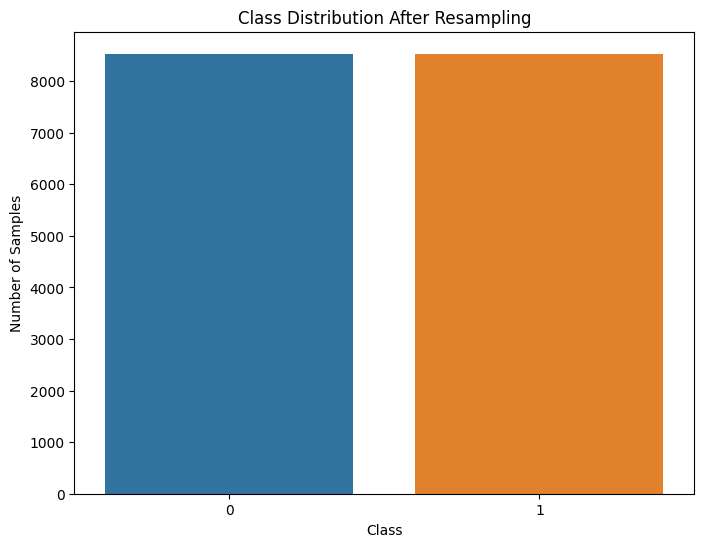

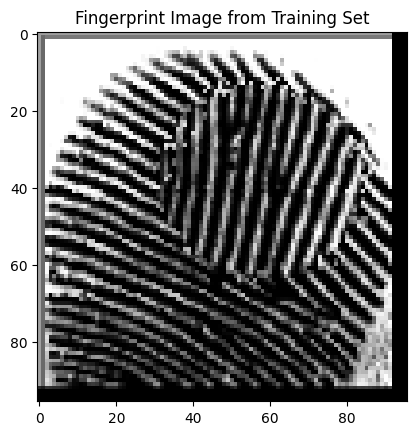

In [13]:
# Define a function to extract labels from image filenames based on folder name
def extract_label(img_path, train=True):
    folder_name = os.path.basename(os.path.dirname(img_path))
    category = 0 if folder_name == 'Real' else 1
    return np.array([category], dtype=np.uint16)
# Define the size for image resizing
img_size = 96

# Define a function to load data from a given path
def loading_data(path, boolean):
    data = []
    for img in os.listdir(path):
        # Read and resize the image
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        
        # Extract label using the extract_label function
        label = extract_label(os.path.join(path, img), boolean)
        
        # Append label and resized image to the data list
        data.append([label[0], img_resize])
        
        # Print progress after processing 1000 images
        if len(data) % 1000 == 0:
            print(len(data))
    return data
# Load altered data from the "Altered-Easy" path using the loading_data function
Altered_path = "C:/Users/HOPIE BABIE/Desktop/HopeB/Altered/Altered-Medium"
altered_data = loading_data(Altered_path, True)

# Split the altered dataset into two halves
altered_half1 = altered_data[:len(altered_data) // 2]
altered_half2 = altered_data[len(altered_data) // 2:]

# Load real data from the "Real" path using the loading_data function
Real_path = "C:/Users/HOPIE BABIE/Desktop/HopeB/Real"
real_data = loading_data(Real_path, True)

# Combine the first half of altered with real data for training
x_train_real = [feature for label, feature in altered_half1]
x_train_real += [feature for label, feature in real_data]
y_train_real = [1] * len(altered_half1) + [0] * len(real_data)

# Display class distribution before oversampling
class_counts_before_resampling = pd.Series(y_train_real).value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts_before_resampling.index, y=class_counts_before_resampling.values)
plt.title('Class Distribution Before Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Oversample the real data to balance classes
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
x_train_real, y_train_real = shuffle(x_train_real, y_train_real, random_state=42)  # Shuffle real data before oversampling
x_train_resampled, y_train_resampled = oversampler.fit_resample(np.array(x_train_real).reshape(-1, img_size * img_size), y_train_real)
x_train_resampled = x_train_resampled.reshape(-1, img_size, img_size, 1)

# Convert x_train_resampled and y_train_resampled to numpy arrays
x_train_resampled = np.array(x_train_resampled)
y_train_resampled = np.array(y_train_resampled)

# Display class distribution after resampling
class_counts_after_resampling = pd.Series(y_train_resampled).value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts_after_resampling.index, y=class_counts_after_resampling.values)
plt.title('Class Distribution After Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Display a fingerprint image from the final training set
plt.imshow(x_train_resampled[0].reshape(img_size, img_size), cmap='gray')
plt.title('Fingerprint Image from Training Set')
plt.show()

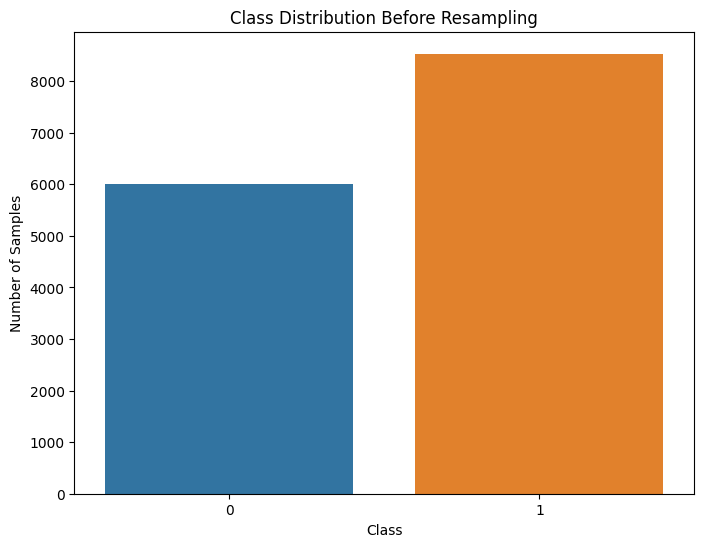

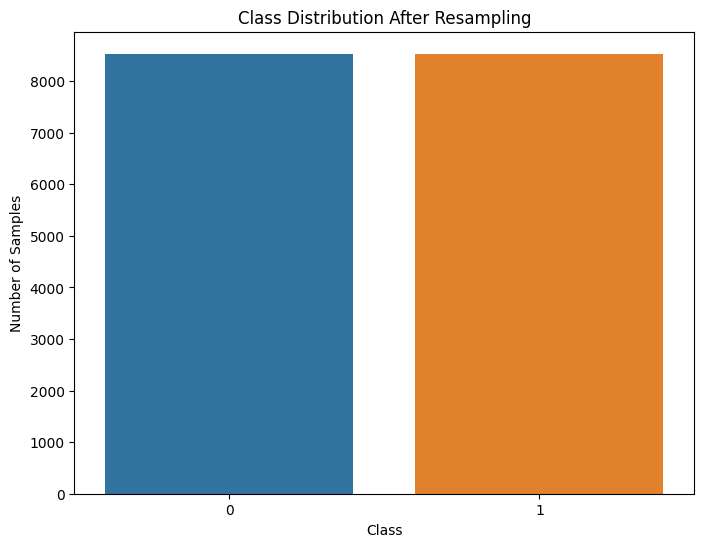

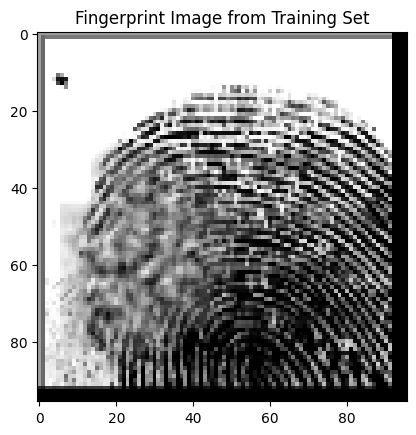

In [14]:
# Combine the second half of altered with real data for training
x_test_real = [feature for label, feature in altered_half2]
x_test_real += [feature for label, feature in real_data]
y_test_real = [1] * len(altered_half2) + [0] * len(real_data)

# Display class distribution before oversampling
class_counts_before_resampling = pd.Series(y_test_real).value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts_before_resampling.index, y=class_counts_before_resampling.values)
plt.title('Class Distribution Before Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Oversample the real data to balance classes
x_test_real, y_test_real = shuffle(x_test_real, y_test_real, random_state=42)  # Shuffle real data before oversampling
x_test_resampled, y_test_resampled = oversampler.fit_resample(np.array(x_test_real).reshape(-1, img_size * img_size), y_test_real)
x_test_resampled = x_test_resampled.reshape(-1, img_size, img_size, 1)

# Convert x_test_resampled and y_test_resampled to numpy arrays
x_test_resampled = np.array(x_test_resampled)
y_test_resampled = np.array(y_test_resampled)

# Display class distribution after resampling
class_counts_after_resampling = pd.Series(y_test_resampled).value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts_after_resampling.index, y=class_counts_after_resampling.values)
plt.title('Class Distribution After Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Display a fingerprint image from the final training set
plt.imshow(x_test_resampled[0].reshape(img_size, img_size), cmap='gray')
plt.title('Fingerprint Image from Training Set')
plt.show()

In [15]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=[96, 96, 1]),
    MaxPooling2D(2),
    Dropout(0.25),  # Add dropout after the first MaxPooling2D layer

    Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
    MaxPooling2D(2),
    Dropout(0.25),  # Add dropout after the second MaxPooling2D layer

    Flatten(),
    Dense(128, kernel_initializer='he_uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Add L2 regularization to the Dense layer
    Dense(1, activation='sigmoid'),
])

model.summary()

model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0

In [16]:
# Train the model using the prepared training data and labels
history = model.fit(
    x_train_resampled,                  # Training images
    y_train_resampled,                      # Training labels
    batch_size=128,              # Number of samples in each training batch
    epochs=24,                   # Number of training epochs
    validation_split=0.2,        # Fraction of training data to use for validation
    callbacks=[early_stopping_cb], # List of callbacks to be applied during training
    verbose=1                    # Verbosity level: 1 shows progress bar
)


Epoch 1/24
107/107 [==============================] - 546s 3s/step - loss: 193.6238 - accuracy: 0.5465 - val_loss: 3.7979 - val_accuracy: 0.1550
Epoch 2/24
107/107 [==============================] - 335s 3s/step - loss: 3.6916 - accuracy: 0.5863 - val_loss: 3.6401 - val_accuracy: 0.1550
Epoch 3/24
107/107 [==============================] - 326s 3s/step - loss: 3.5184 - accuracy: 0.5863 - val_loss: 3.4989 - val_accuracy: 0.1550
Epoch 4/24
107/107 [==============================] - 325s 3s/step - loss: 3.3625 - accuracy: 0.5863 - val_loss: 3.3719 - val_accuracy: 0.1550
Epoch 5/24
107/107 [==============================] - 331s 3s/step - loss: 3.2216 - accuracy: 0.5863 - val_loss: 3.2546 - val_accuracy: 0.1550
Epoch 6/24
107/107 [==============================] - 320s 3s/step - loss: 3.0933 - accuracy: 0.5863 - val_loss: 3.1455 - val_accuracy: 0.1550
Epoch 7/24
107/107 [==============================] - 328s 3s/step - loss: 2.9756 - accuracy: 0.5863 - val_loss: 3.0435 - val_accuracy: 0.15

534/534 [==============================] - 102s 177ms/step - loss: 1.7806 - accuracy: 0.5000
Test Loss: 1.7806, Test Accuracy: 0.5000
534/534 [==============================] - 115s 171ms/step


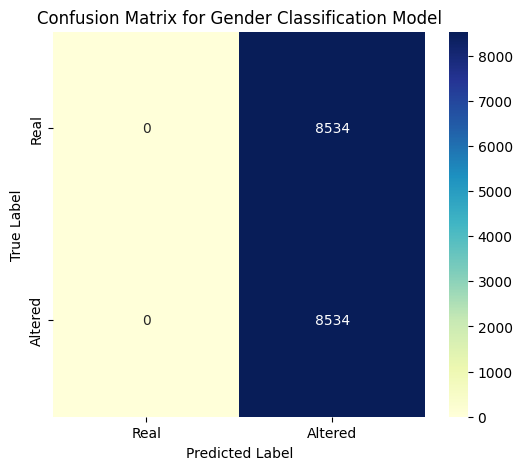

Classification Report:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00      8534
     Altered       0.50      1.00      0.67      8534

    accuracy                           0.50     17068
   macro avg       0.25      0.50      0.33     17068
weighted avg       0.25      0.50      0.33     17068



c:\Users\HOPIE BABIE\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOPIE BABIE\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HOPIE BABIE\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [17]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test_resampled, y_test_resampled)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict labels on the test set
preds = model.predict(x_test_resampled)
preds = (preds >= 0.5).astype(np.int32)

# Compute confusion matrix
cm = confusion_matrix(y_test_resampled, preds)
df_cm = pd.DataFrame(cm, index=['Real', 'Altered'], columns=['Real', 'Altered'])

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix for Gender Classification Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Compute classification report for precision, recall, F1-score, etc.
class_report = classification_report(y_test_resampled, preds, target_names=['Real', 'Altered'])
print("Classification Report:")
print(class_report)

In [18]:
real_samples = np.sum(y_test_resampled == 0)
altered_samples = np.sum(y_test_resampled == 1)
print(f"Real samples in test set: {real_samples}")
print(f"Altered samples in test set: {altered_samples}")

Real samples in test set: 8534
Altered samples in test set: 8534


In [19]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same', kernel_initializer='he_uniform')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x
input_shape = (96, 96, 1)

inputs = Input(shape=input_shape)
x = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.25)(x)

x = resnet_block(x, filters=32)
x = MaxPooling2D(2)(x)
x = Dropout(0.25)(x)

x = resnet_block(x, filters=64)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)

model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 96, 96, 32)           320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 96, 96, 32)           128       ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 32)           0         ['batch_normalization[0][0

In [20]:
# Train the model using the prepared training data and labels
history = model.fit(
    x_train_resampled,                  # Training images
    y_train_resampled,                      # Training labels
    batch_size=128,              # Number of samples in each training batch
    epochs=24,                   # Number of training epochs
    validation_split=0.2,        # Fraction of training data to use for validation
    callbacks=[early_stopping_cb], # List of callbacks to be applied during training
    verbose=1                    # Verbosity level: 1 shows progress bar
)


Epoch 1/24
107/107 [==============================] - 861s 8s/step - loss: 2.1424 - accuracy: 0.8121 - val_loss: 3.4357 - val_accuracy: 0.8448
Epoch 2/24
107/107 [==============================] - 754s 7s/step - loss: 0.9134 - accuracy: 0.9163 - val_loss: 0.9760 - val_accuracy: 0.8020
Epoch 3/24
107/107 [==============================] - 764s 7s/step - loss: 0.4299 - accuracy: 0.9530 - val_loss: 0.4524 - val_accuracy: 0.9036
Epoch 4/24
107/107 [==============================] - 772s 7s/step - loss: 0.2408 - accuracy: 0.9636 - val_loss: 0.2499 - val_accuracy: 0.9572
Epoch 5/24
107/107 [==============================] - 760s 7s/step - loss: 0.1600 - accuracy: 0.9697 - val_loss: 0.1080 - val_accuracy: 0.9807
Epoch 6/24
107/107 [==============================] - 758s 7s/step - loss: 0.1220 - accuracy: 0.9726 - val_loss: 0.0869 - val_accuracy: 0.9815
Epoch 7/24
107/107 [==============================] - 864s 8s/step - loss: 0.1103 - accuracy: 0.9729 - val_loss: 0.1035 - val_accuracy: 0.9701

534/534 [==============================] - 276s 502ms/step - loss: 0.0748 - accuracy: 0.9735
Test Loss: 0.0748, Test Accuracy: 0.9735
534/534 [==============================] - 291s 517ms/step


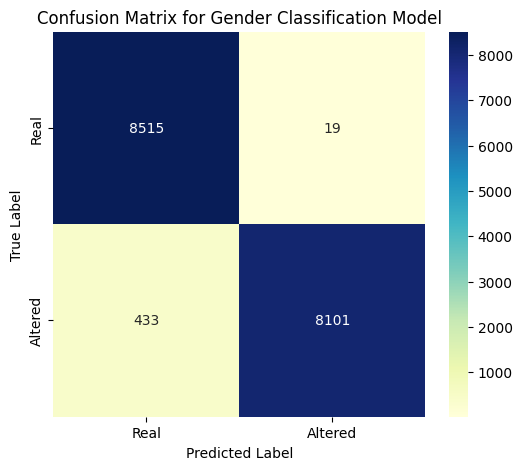

Classification Report:
              precision    recall  f1-score   support

        Real       0.95      1.00      0.97      8534
     Altered       1.00      0.95      0.97      8534

    accuracy                           0.97     17068
   macro avg       0.97      0.97      0.97     17068
weighted avg       0.97      0.97      0.97     17068



In [21]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test_resampled, y_test_resampled)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict labels on the test set
preds = model.predict(x_test_resampled)
preds = (preds >= 0.5).astype(np.int32)

# Compute confusion matrix
cm = confusion_matrix(y_test_resampled, preds)
df_cm = pd.DataFrame(cm, index=['Real', 'Altered'], columns=['Real', 'Altered'])

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix for Gender Classification Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Compute classification report for precision, recall, F1-score, etc.
class_report = classification_report(y_test_resampled, preds, target_names=['Real', 'Altered'])
print("Classification Report:")
print(class_report)

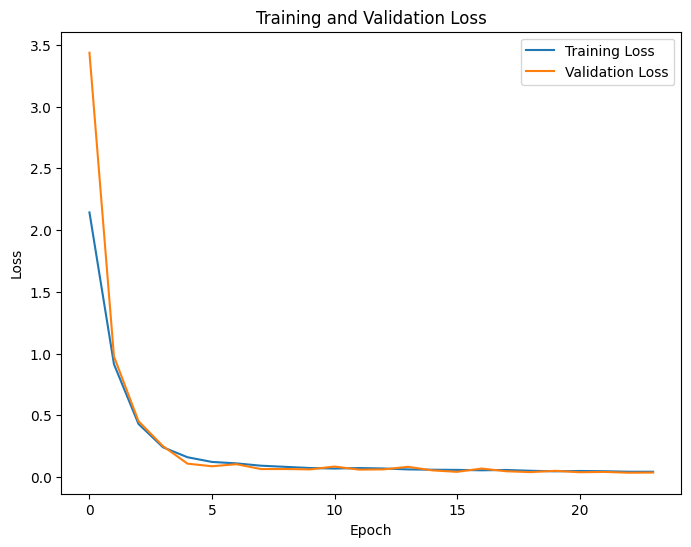

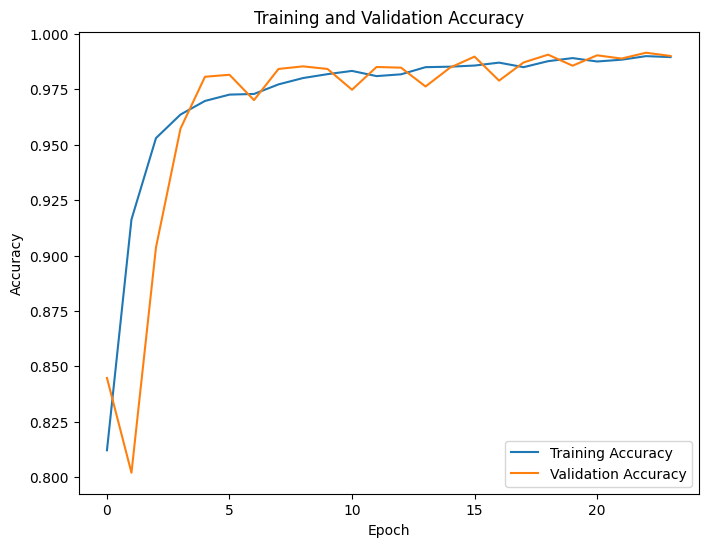

In [22]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [23]:
model.save("C:/Users/HOPIE BABIE/Desktop/HopeB/RVA.keras")

In [ ]:
#loading model trained on Easy Altered
#model2 = load_model("RVA.keras")
#use this to load the model

In [ ]:
from keras.models import load_model

model = load_model("C:/Users/HOPIE BABIE/Desktop/HopeB/RVA.keras")


